# Evaluate Trained Model
Predict classes on test set with trained model(s)
Evaluate test predictions

train obs:  490702 val obs:  112779 test obs:  149321 

 Train % epidural:  0.43% 
 Validation % epidural:  0.39% 
 Test % epidural:  0.38% 

 Train % intraparenchymal:  4.78% 
 Validation % intraparenchymal:  4.87% 
 Test % intraparenchymal:  4.79% 

 Train % intraventricular:  3.45% 
 Validation % intraventricular:  3.30% 
 Test % intraventricular:  3.71% 

 Train % subarachnoid:  4.68% 
 Validation % subarachnoid:  4.88% 
 Test % subarachnoid:  4.81% 

 Train % subdural:  6.11% 
 Validation % subdural:  6.71% 
 Test % subdural:  6.45% 

 Train % any:  14.24% 
 Validation % any:  14.40% 
 Test % any:  14.61% 

train obs:  4908
val obs:  1128
 Train % epidural:  0.51% 
 Validation % epidural:  0.44% 

 Train % intraparenchymal:  4.26% 
 Validation % intraparenchymal:  5.67% 

 Train % intraventricular:  3.63% 
 Validation % intraventricular:  2.84% 

 Train % subarachnoid:  4.79% 
 Validation % subarachnoid:  5.41% 

 Train % subdural:  5.97% 
 Validation % subdural:  5.67% 

 Train %

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([0, 0, 0, 0, 0, 0])
ID_000039fa0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([0, 0, 0, 0, 0, 0])
ID_000039fa0


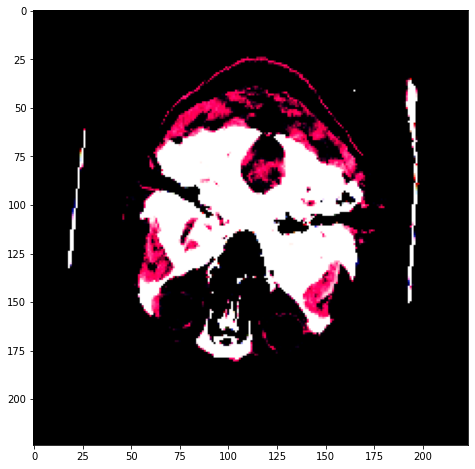

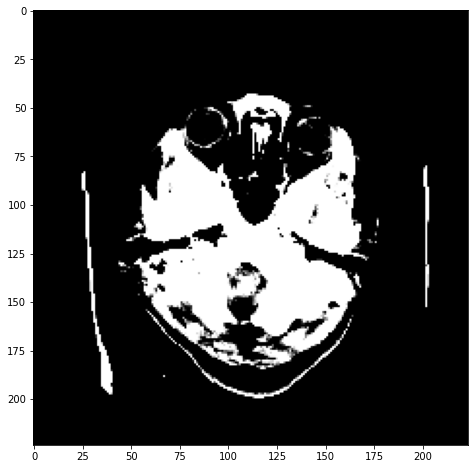

In [1]:
# Packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import pydicom
import PIL
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
import torch.optim as optim
import time
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, log_loss, precision_recall_curve, auc, accuracy_score
import itertools
from itertools import cycle
from data_preprocessing import * # preprocessing script for this project

# Device
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# Global paths
dpath = '/rsna-intracranial-hemorrhage-detection/'
trpath = '/rsna-intracranial-hemorrhage-detection/stage_2_train/'

# Randomness
random.seed(2021)
np.random.seed(2021)
torch.manual_seed(2021)

Dataloader

In [2]:
# Dataloader
test_df_path = './data/df_test.csv'
transformed_dataset = {'test':RSNADataset_3chan(test_df_path, trpath, transform=val_transform)}
bs = 32

dataloader['test'] = DataLoader(transformed_dataset['test'], batch_size=bs,
                        shuffle=False, num_workers=0)
data_sizes = {'test': len(transformed_dataset['test'])}

Long test set for calc log loss

In [3]:
df_test = pd.read_csv('./data/df_test.csv')

# df_test_l = pd.DataFrame()
# for i in df_test.index:
#     ind = i+1
#     df_id = pd.melt(df_test[i:ind], id_vars='Image ID',
#                     value_vars=['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any'],
#                     var_name='subtype', value_name='Label')
#     df_test_l = pd.concat([df_test_l, df_id], ignore_index=True)
    
# df_test_l.to_csv('./data/df_test_l.csv', index=False)

df_test_l = pd.read_csv('./data/df_test_l.csv')
df_test_l

,Image ID,subtype,Label
0,ID_0001f7f62,epidural,0
1,ID_0001f7f62,intraparenchymal,0
2,ID_0001f7f62,intraventricular,0
3,ID_0001f7f62,subarachnoid,0
4,ID_0001f7f62,subdural,0
...,...,...,...
895921,ID_ffff82e46,intraparenchymal,0
895922,ID_ffff82e46,intraventricular,0
895923,ID_ffff82e46,subarachnoid,0
895924,ID_ffff82e46,subdural,0


Load model

In [4]:
# Full model
# MOD_PATH = './models/dense121_sub.pt' # subset
# MOD_PATH = './models/dense121.pt' # full training data
# dense121_trained = torch.load(MOD_PATH)
# dense121_trained.eval()

# From dict
DICT_PATH = './models/dense121_9.pt'

dense121_trained = models.densenet121(pretrained=False)
num_ftrs = dense121_trained.classifier.in_features
dense121_trained.classifier = nn.Sequential(nn.Linear(num_ftrs, 6),
                                    nn.Sigmoid())

dense121_trained.load_state_dict(torch.load(DICT_PATH))
dense121_trained = dense121_trained.to(device)

Make predictions on test set

In [5]:
def test_preds(model, dataloader):
    since = time.time()
    probs_list = []
    preds_list = []
    labs_list = []

    for data in dataloader:
        image = data['image'].float().to(device)
        label = data['class'].float().to(device)
    #     img_id = data['img_id']
        output = dense121_trained(image)
        preds = torch.where(output > 0.4, 1, 0)
        probs_list.extend(output.squeeze().tolist())
        labs_list.extend(label.squeeze().tolist())
        preds_list.extend(preds.squeeze().tolist())
    #     id_list.extend(img_id)
    time_elapsed = time.time() - since
    print('Prediction complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return probs_list, labs_list, preds_list
    
probs_list, labs_list, preds_list = test_preds(dense121_trained, dataloader['test'])

print(probs_list[0:13])
print(labs_list[0:13])
print(preds_list[0:13])

Prediction complete in 48m 22s
[[0.00010351093806093559, 0.00013323541497811675, 3.292717519798316e-05, 0.00010326869960408658, 0.00027269148267805576, 0.0005493061034940183], [0.00018611161794979125, 0.0008450166787952185, 0.00011665753117995337, 0.0006307594012469053, 0.002210331382229924, 0.0035751163959503174], [0.0036989387590438128, 0.9846153855323792, 0.007993240840733051, 0.08285045623779297, 0.04980074614286423, 0.986431896686554], [2.2525629901792854e-05, 0.00023285529459826648, 3.8761296309530735e-05, 0.0004065300745423883, 0.000836550141684711, 0.001974087907001376], [0.0024105992633849382, 0.0009270898881368339, 5.9967016568407416e-05, 0.002712720539420843, 0.14364460110664368, 0.11223326623439789], [3.6865782021777704e-05, 0.001559033989906311, 0.0010845564538612962, 0.0034485545475035906, 0.005768127739429474, 0.012796866707503796], [3.3799635275499895e-05, 7.042726065265015e-05, 9.618639160180464e-05, 0.0003828422341030091, 0.0003099697350990027, 0.0007519363425672054],

In [6]:
# Flatten lists
probs_list_flat =  [item for sublist in probs_list for item in sublist]
labs_list_flat = [item for sublist in labs_list for item in sublist]
preds_list_flat = [item for sublist in preds_list for item in sublist]

In [7]:
# Append predictions to df_test_l
df_test_l['Probs'] = probs_list_flat
df_test_l['preds test'] = preds_list_flat

# Adjust probabilities for log loss
def probs_adjust(row):
    return max(min(row['Probs'], 1-10e-15),10e-15)

# Calc log loss
def probs_log_loss(row):
    return -(row['Label']*np.log(row['Probs adjust']) + (1-row['Label'])*np.log(1-row['Probs adjust']))

df_test_l['Probs adjust'] = df_test_l.apply(lambda row : probs_adjust(row), axis=1)
df_test_l['Log Loss'] = df_test_l.apply(lambda row : probs_log_loss(row), axis=1)

# Individual classes
df_test_epidural = df_test_l.loc[df_test_l['subtype'] == 'epidural'].reset_index(drop=True)
df_test_intraparenchymal = df_test_l.loc[df_test_l['subtype'] == 'intraparenchymal'].reset_index(drop=True)
df_test_intraventricular = df_test_l.loc[df_test_l['subtype'] == 'intraventricular'].reset_index(drop=True)
df_test_subarachnoid = df_test_l.loc[df_test_l['subtype'] == 'subarachnoid'].reset_index(drop=True)
df_test_subdural = df_test_l.loc[df_test_l['subtype'] == 'subdural'].reset_index(drop=True)
df_test_any = df_test_l.loc[df_test_l['subtype'] == 'any'].reset_index(drop=True)

In [8]:
# Average log loss - entire dataset
print('All classes: ', df_test_l['Log Loss'].mean())

# Average log loss by subclass
print('Epidural: ', df_test_epidural['Log Loss'].mean())
print('Intraparenchymal: ', df_test_intraparenchymal['Log Loss'].mean())
print('Intraventricular: ', df_test_intraventricular['Log Loss'].mean())
print('Subarachnoid: ', df_test_subarachnoid['Log Loss'].mean())
print('Subdural: ', df_test_subdural['Log Loss'].mean())
print('Any: ', df_test_any['Log Loss'].mean())

All classes:  0.06738987852171643
Epidural:  0.016266623031374213
Intraparenchymal:  0.05353872209198141
Intraventricular:  0.03421899271288338
Subarachnoid:  0.08146500703018193
Subdural:  0.09580333736908264
Any:  0.12304658889479492


In [9]:
classes = ['All classes', 'Epidural', 'Intraparenchymal', 'Intraventricular', 'Subarachnoid', 'Subdural', 'Any']
accuracy = [accuracy_score(list(df_test_l['Label']), list(df_test_l['preds test'])),
            accuracy_score(list(df_test_epidural['Label']), list(df_test_epidural['preds test'])),
            accuracy_score(list(df_test_intraparenchymal['Label']), list(df_test_intraparenchymal['preds test'])),
            accuracy_score(list(df_test_intraventricular['Label']), list(df_test_intraventricular['preds test'])),
            accuracy_score(list(df_test_subarachnoid['Label']), list(df_test_subarachnoid['preds test'])),
            accuracy_score(list(df_test_subdural['Label']), list(df_test_subdural['preds test'])),
            accuracy_score(list(df_test_any['Label']), list(df_test_any['preds test']))]
loss = [df_test_l['Log Loss'].mean(),
        df_test_epidural['Log Loss'].mean(),
        df_test_intraparenchymal['Log Loss'].mean(),
        df_test_intraventricular['Log Loss'].mean(),
        df_test_subarachnoid['Log Loss'].mean(),
        df_test_subdural['Log Loss'].mean(), 
        df_test_any['Log Loss'].mean()]

d = {'Class': classes, 'Accuracy': accuracy, 'Avg Log Loss': loss}
acc_loss_df = pd.DataFrame(data=d)
acc_loss_df.to_csv('./figs/acc_loss.csv')

Eval functions

In [10]:
##################################### ROC AUC Curve
        # https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
def ROC_AUC(probs, labs, title, path):
    # calculate the fpr and tpr for all thresholds of the classification
    # true labels
    labs = np.array(labs)

    # no skill probs
    ns_probs = [0 for _ in range(len(labs))]
    # keep probabilities for the positive outcome only
    probs_test = np.array(probs) # [:, 1] # all probs are for positive outcome in this case
    # calculate scores
    test_auc = roc_auc_score(labs, probs_test)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(labs, ns_probs)
    test_fpr, test_tpr, _ = roc_curve(labs, probs_test)
    # plot the roc curve for the model
    plt.figure(figsize=(20, 14))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', color='black')
    plt.plot(test_fpr, test_tpr, marker=None, label='Test ROC AUC={:.3f}'.format(test_auc), color='#ff7f0e')
    plt.title(title, fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend(loc='lower right', fontsize=14)
    
    plt.savefig(path)
    plt.show()
    

##################################### Precision-recall curves
def PR_curve(probs, labs, subclass, color):
    # calculate the fpr and tpr for all thresholds of the classification
    # true labels
    labs = np.array(labs)

    # no skill probs
    probs_test = np.array(probs) # [:, 1] # all probs are for positive outcome in this case

    # calculate roc curves
    test_precision, test_recall, _ = precision_recall_curve(labs, probs_test)
    
    # auc
    test_auc = auc(test_recall, test_precision)
    
    # plot the PR curve for the model
    return plt.plot(test_precision, test_recall, marker=None, label='{0} Test PR AUC={1:.3f}'.format(subclass, test_auc), color=color)



##################################### Confusion matrix
        # https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          path,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] >= thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] >= thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(path)
    plt.show()

ROC AUC Curves

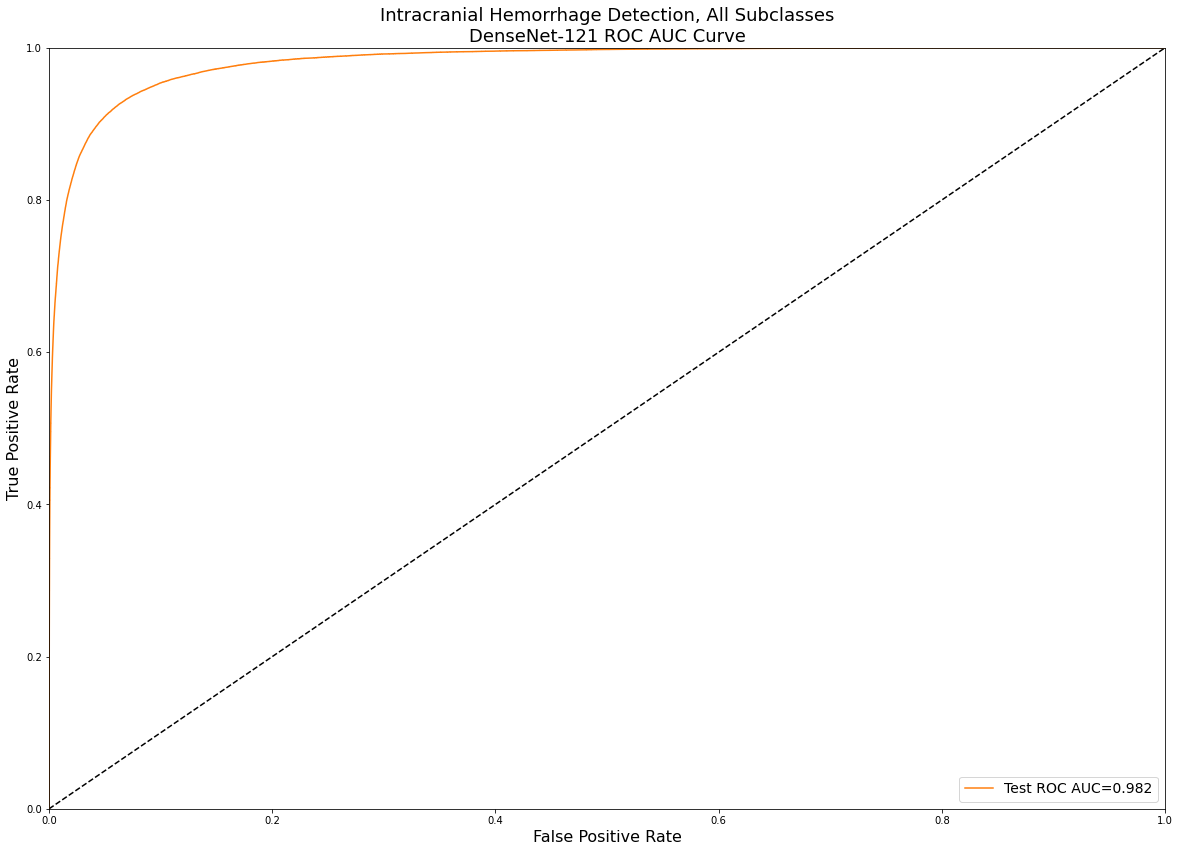

In [11]:
# All classes combined
ROC_AUC(probs_list_flat, labs_list_flat,
        'Intracranial Hemorrhage Detection, All Subclasses\nDenseNet-121 ROC AUC Curve',
        './figs/test_roc_auc_all.png')

# Individual classes
# ROC_AUC()

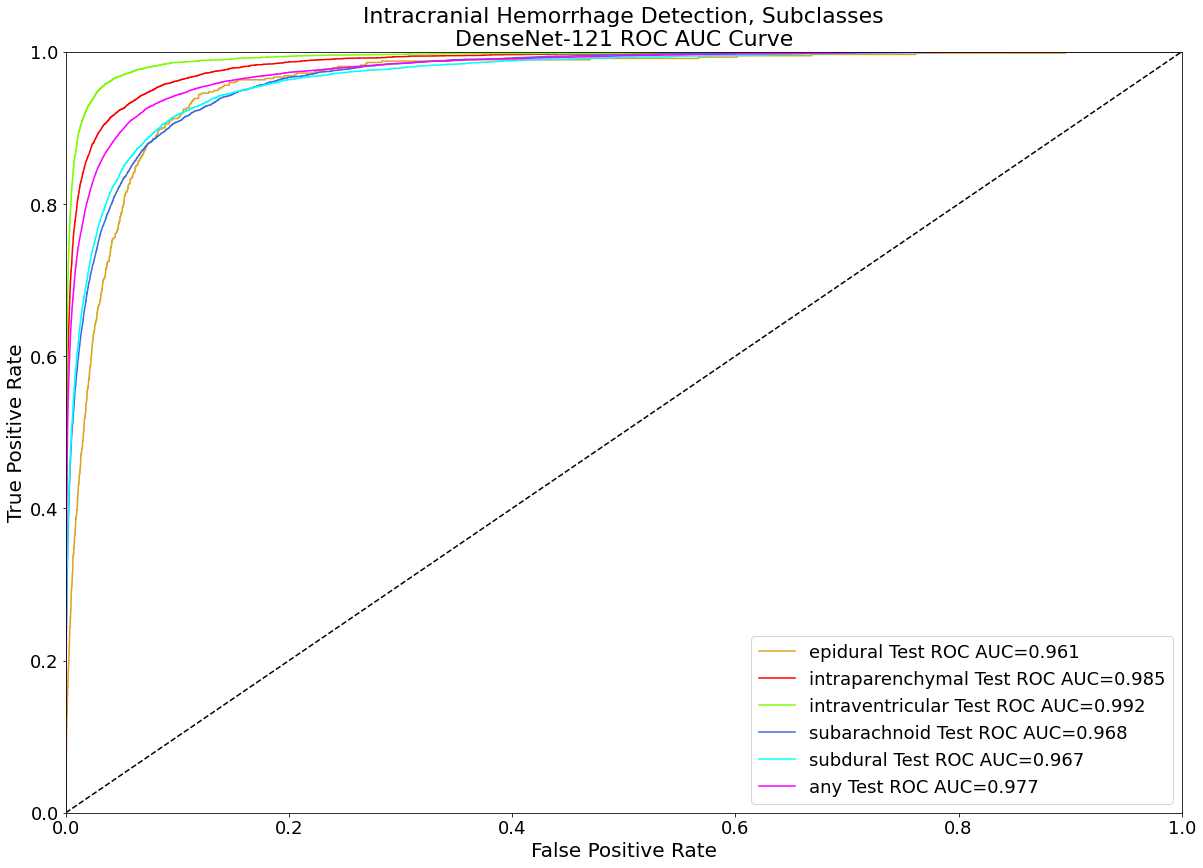

In [16]:
def ROC_AUC(probs, labs, subclass, color):
    # calculate the fpr and tpr for all thresholds of the classification
    # true labels
    labs = np.array(labs)

    # keep probabilities for the positive outcome only
    probs_test = np.array(probs) # [:, 1] # all probs are for positive outcome in this case
    # calculate scores
    test_auc = roc_auc_score(labs, probs_test)

    # calculate roc curves
    test_fpr, test_tpr, _ = roc_curve(labs, probs_test)
    # plot the roc curve for the model
    return plt.plot(test_fpr, test_tpr, marker=None, label='{0} Test ROC AUC={1:.3f}'.format(subclass, test_auc), color=color)

subclasses = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']
colors = cycle(['goldenrod', 'red', 'lawngreen', 'royalblue', 'aqua', 'fuchsia'])

# no skill probs 
labs_any = list(df_test_l.loc[df_test_l['subtype'] == 'any']['Label'])
ns_probs = [0 for _ in range(len(labs_any))]
ns_fpr, ns_tpr, _ = roc_curve(labs_any, ns_probs)


plt.figure(figsize=(20, 14))
plt.plot(ns_fpr, ns_tpr, linestyle='--', color='black')

for sub, color in zip(subclasses, colors):
    probs = list(df_test_l.loc[df_test_l['subtype'] == sub]['Probs'])
    labs = list(df_test_l.loc[df_test_l['subtype'] == sub]['Label'])
    ROC_AUC(probs, labs, sub, color)

plt.title('Intracranial Hemorrhage Detection, Subclasses\nDenseNet-121 ROC AUC Curve', fontsize=22)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=18)

plt.savefig('./figs/test_roc_subs.png')
plt.show()

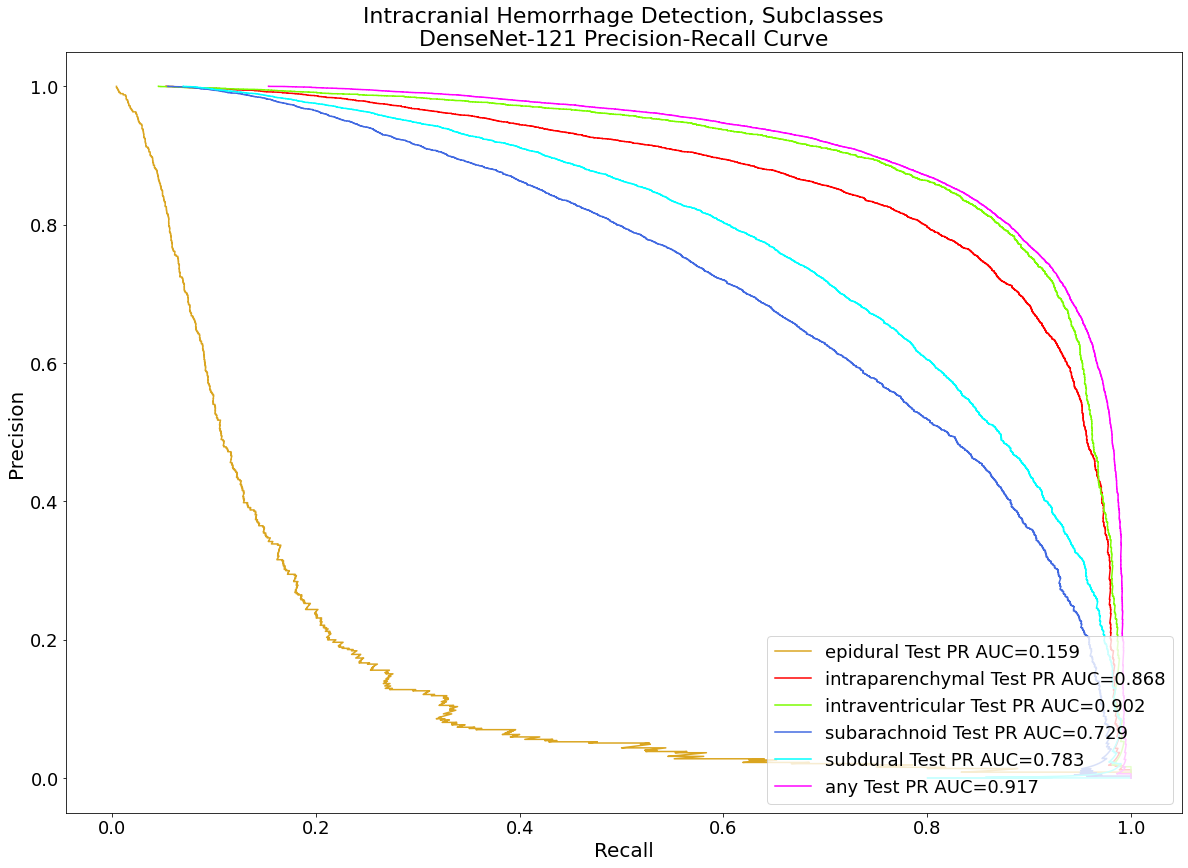

In [17]:
# no skill probs 
labs_any = list(df_test_l.loc[df_test_l['subtype'] == 'any']['Label'])
ns_probs = [0 for _ in range(len(labs_any))]
ns_precision, ns_recall, _ = precision_recall_curve(labs_any, ns_probs)

plt.figure(figsize=(20, 14))
# plt.plot(ns_precision, ns_recall, linestyle='--', color='black')

for sub, color in zip(subclasses, colors):
    probs = list(df_test_l.loc[df_test_l['subtype'] == sub]['Probs'])
    labs = list(df_test_l.loc[df_test_l['subtype'] == sub]['Label'])
    PR_curve(probs, labs, sub, color)

plt.title('Intracranial Hemorrhage Detection, Subclasses\nDenseNet-121 Precision-Recall Curve', fontsize=22)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=18)

plt.savefig('./figs/test_pr_subs.png')
plt.show()

Confusion matrices

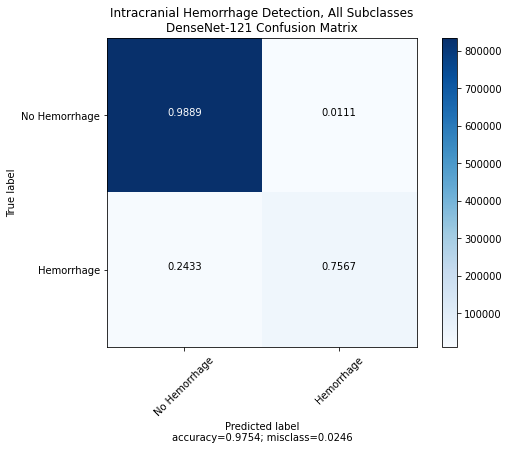

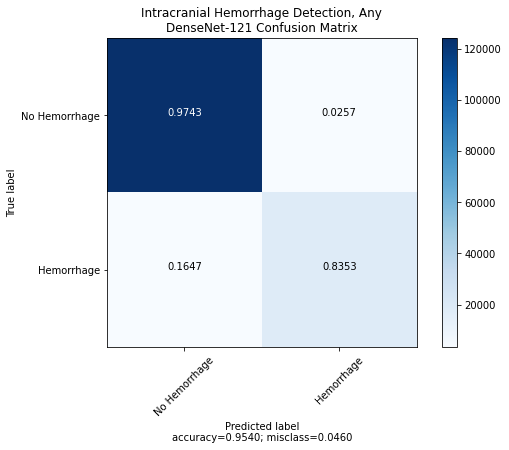

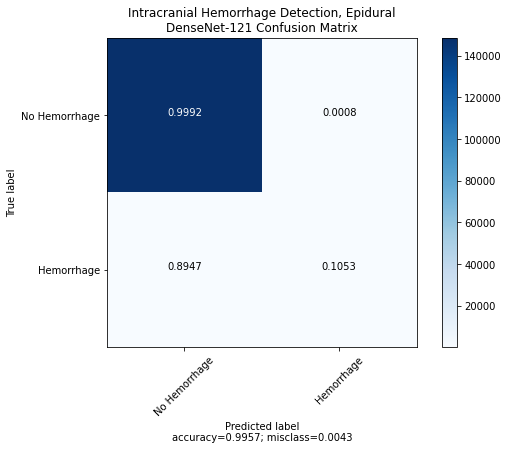

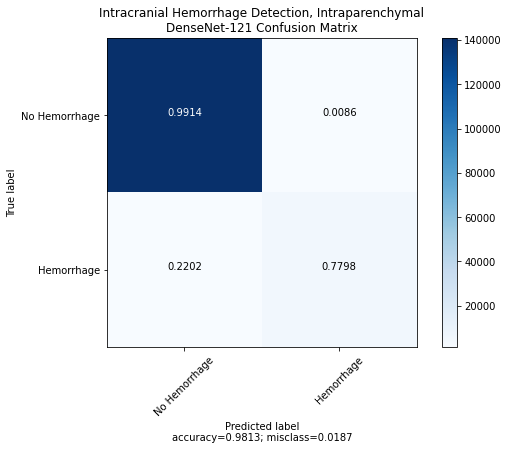

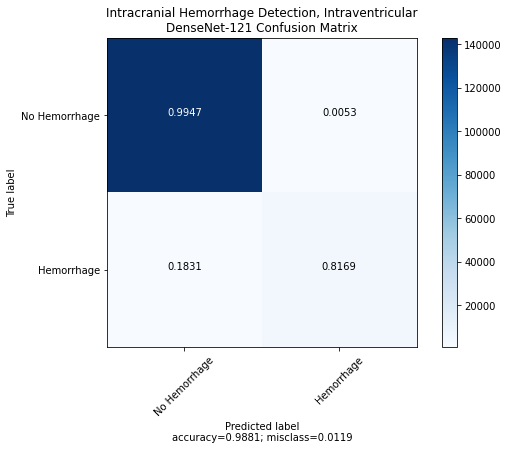

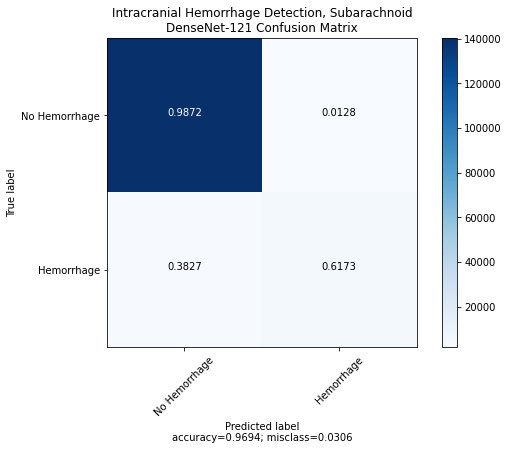

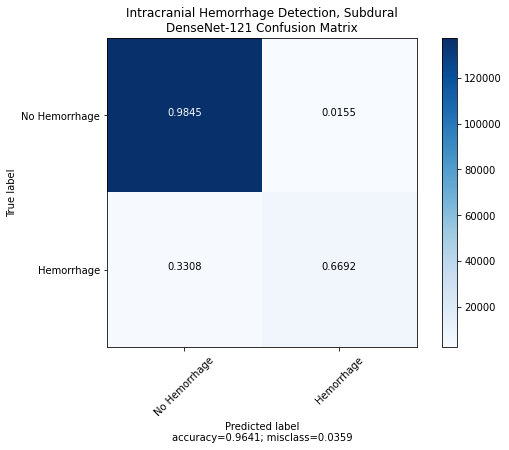

In [18]:
# All classes combined
plot_confusion_matrix(confusion_matrix(labs_list_flat, preds_list_flat),
                      target_names=['No Hemorrhage', 'Hemorrhage'],
                      path='./figs/test_cm_all.png',
                      title='Intracranial Hemorrhage Detection, All Subclasses\nDenseNet-121 Confusion Matrix',
                      normalize=True)
# Individual classes
        # Any
plot_confusion_matrix(confusion_matrix(list(df_test_any['Label']), list(df_test_any['preds test'])),
                      target_names=['No Hemorrhage', 'Hemorrhage'],
                      title='Intracranial Hemorrhage Detection, Any\nDenseNet-121 Confusion Matrix',
                      path='./figs/test_cm_any.png',
                      normalize=True)
        # Epidural
plot_confusion_matrix(confusion_matrix(list(df_test_epidural['Label']), list(df_test_epidural['preds test'])),
                      target_names=['No Hemorrhage', 'Hemorrhage'],
                      title='Intracranial Hemorrhage Detection, Epidural\nDenseNet-121 Confusion Matrix',
                      path='./figs/test_cm_epidural.png',
                      normalize=True)

        # Intraparenchymal
plot_confusion_matrix(confusion_matrix(list(df_test_intraparenchymal['Label']), list(df_test_intraparenchymal['preds test'])),
                      target_names=['No Hemorrhage', 'Hemorrhage'],
                      title='Intracranial Hemorrhage Detection, Intraparenchymal\nDenseNet-121 Confusion Matrix',
                      path='./figs/test_cm_intraparenchymal.png',
                      normalize=True)
        # Intraventricular
plot_confusion_matrix(confusion_matrix(list(df_test_intraventricular['Label']), list(df_test_intraventricular['preds test'])),
                      target_names=['No Hemorrhage', 'Hemorrhage'],
                      title='Intracranial Hemorrhage Detection, Intraventricular\nDenseNet-121 Confusion Matrix',
                      path='./figs/test_cm_intraventricular.png',
                      normalize=True)
        # Subarachnoid
plot_confusion_matrix(confusion_matrix(list(df_test_subarachnoid['Label']), list(df_test_subarachnoid['preds test'])),
                      target_names=['No Hemorrhage', 'Hemorrhage'],
                      title='Intracranial Hemorrhage Detection, Subarachnoid\nDenseNet-121 Confusion Matrix',
                      path='./figs/test_cm_subarachnoid.png',
                      normalize=True)
        # Subdural
plot_confusion_matrix(confusion_matrix(list(df_test_subdural['Label']), list(df_test_subdural['preds test'])),
                      target_names=['No Hemorrhage', 'Hemorrhage'],
                      title='Intracranial Hemorrhage Detection, Subdural\nDenseNet-121 Confusion Matrix',
                      path='./figs/test_cm_subdural.png',
                      normalize=True)